# Predicting missing values of player stats in fifa22 dataset using RandomForestRegressor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

# --- Load dataset ---
df = pd.read_csv("fifa22_cleaned_with_workrate.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16710 entries, 0 to 16709
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        16710 non-null  int64  
 1   Name                      16710 non-null  object 
 2   Age                       16710 non-null  int64  
 3   Nationality               16710 non-null  object 
 4   Overall                   16710 non-null  int64  
 5   Potential                 16710 non-null  int64  
 6   Club                      16446 non-null  object 
 7   Value                     16710 non-null  float64
 8   Wage                      16710 non-null  float64
 9   Special                   16710 non-null  int64  
 10  Preferred Foot            16710 non-null  object 
 11  International Reputation  16710 non-null  float64
 12  Weak Foot                 16710 non-null  float64
 13  Skill Moves               16710 non-null  float64
 14  Work R

## Defining classes and determinant features (can be enlarged to improve accuracy)

In [2]:
def map_position_group(pos):
    if pos in ['GK']:
        return 'GK'
    elif pos in ['CB', 'LCB', 'RCB']:
        return 'Defender'
    elif pos in ['LB', 'RB', 'LWB', 'RWB']:
        return 'Fullback'
    elif pos in ['CDM', 'CM', 'CAM']:
        return 'Midfielder'
    elif pos in ['LW', 'RW', 'LM', 'RM']:
        return 'Winger'
    elif pos in ['ST', 'CF', 'LS', 'RS']:
        return 'Forward'
    else:
        return 'Other'

# Add position group if not present
def add_position_group(df):
    if 'PosGroup' not in df.columns:
        df['PosGroup'] = df['Position'].apply(map_position_group)
    return df

#feature being used for predicting respective features
feature_dict = {
    'Volleys': ['Finishing', 'ShotPower', 'BallControl', 'Dribbling', 'Overall'],
    'Curve': ['FKAccuracy', 'Crossing', 'BallControl', 'LongShots', 'Overall'],
    'Agility': ['Balance', 'Acceleration', 'Dribbling', 'Reactions', 'Overall'],
    'Balance': ['Agility', 'Dribbling', 'Acceleration', 'Overall'],
    'Jumping': ['Strength', 'HeadingAccuracy', 'Aggression', 'Overall'],
    'Interceptions': ['StandingTackle', 'DefensiveAwareness', 'Aggression', 'Overall'],
    'Positioning': ['Finishing', 'Vision', 'Reactions', 'Overall'],
    'Vision': ['ShortPassing', 'LongPassing', 'BallControl', 'Overall'],
    'Composure': ['Reactions', 'BallControl', 'Vision', 'Overall'],
    'Marking': ['StandingTackle', 'DefensiveAwareness', 'Interceptions', 'Overall'],
    'SlidingTackle': ['StandingTackle', 'DefensiveAwareness', 'Aggression', 'Overall'],
    'DefensiveAwareness': ['StandingTackle', 'Interceptions', 'Aggression', 'Overall']
}

## randomForestRegressor model, wrapped inside a function

In [3]:
def predict_missing_attribute(df, target_attr):
    """
    Predicts missing FIFA attribute values using correlated features, player position,
    and overall rating. Automatically fits, evaluates, plots, and fills missing values.
    Prints progress updates throughout processing.
    """

    print(f"\n{'='*80}")
    print(f"Starting prediction for attribute: {target_attr}")
    print(f"{'='*80}")

    # Step 1: Add position groups
    print("Step 1: Ensuring position groups are defined...")
    df = add_position_group(df)

    # Step 2: Validate target feature
    if target_attr not in feature_dict:
        print(f"ERROR: '{target_attr}' not found in feature dictionary.")
        raise ValueError(f"'{target_attr}' not found in predefined feature set.")

    features = feature_dict[target_attr]
    print(f"Step 2: Selected input features: {features}")

    # Step 3: Clean data
    print("Step 3: Cleaning data and removing rows with missing predictor values...")
    data = df[features + ['PosGroup', target_attr]].copy()
    data = data.dropna(subset=features)
    known_data = data.dropna(subset=[target_attr])

    print(f"Found {len(known_data)} valid samples with known '{target_attr}' values.")

    if known_data.shape[0] < 100:
        print(f"Not enough data to train a model for {target_attr} ({len(known_data)} samples). Skipping...")
        return df

    # Step 4: Prepare data
    print("Step 4: Preparing model input data...")
    X = known_data[features + ['PosGroup']]
    y = known_data[target_attr]

    # Step 5: Create model pipeline
    print("Step 5: Building preprocessing and model pipeline...")
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['PosGroup']),
        ('num', 'passthrough', features)
    ])

    model = Pipeline([
        ('prep', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=300, random_state=42))
    ])

    # Step 6: Split and train
    print("Step 6: Splitting data and training model...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model.fit(X_train, y_train)
    print("Model training complete!")

    # Step 7: Evaluate performance
    print("Step 7: Evaluating model performance...")
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\nModel Performance for {target_attr}")
    print(f"   -> R² Score: {r2:.3f}")
    print(f"   -> Mean Absolute Error: {mae:.3f}")

    # Step 8: Correlation heatmap
    print("\nStep 8: Plotting correlation heatmap...")
    corr = known_data[features + [target_attr]].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f"Correlation Heatmap for {target_attr}")
    plt.show()

    # Step 9: Actual vs Predicted plot
    print("Step 9: Plotting actual vs predicted scatter plot...")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.title(f"{target_attr}: Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    # Step 10: Predict missing values
    print("\nStep 10: Predicting missing values...")
    missing_mask = df[target_attr].isna()
    missing_count = missing_mask.sum()

    if missing_count > 0:
        print(f"   → Found {missing_count} missing '{target_attr}' values. Predicting now...")
        X_missing = df.loc[missing_mask, features + ['PosGroup']]
        preds = model.predict(X_missing)
        df.loc[missing_mask, target_attr] = np.clip(preds, 0, 99)
        print(f"Successfully filled {missing_count} missing values for {target_attr}.")
    else:
        print(f"No missing values found for {target_attr}.")

    print(f"\nFinished processing attribute: {target_attr}")
    print(f"{'='*80}\n")

    return df


## Predicting the values (except Marking : since have samll dataset)


Starting prediction for attribute: Volleys
Step 1: Ensuring position groups are defined...
Step 2: Selected input features: ['Finishing', 'ShotPower', 'BallControl', 'Dribbling', 'Overall']
Step 3: Cleaning data and removing rows with missing predictor values...
Found 16673 valid samples with known 'Volleys' values.
Step 4: Preparing model input data...
Step 5: Building preprocessing and model pipeline...
Step 6: Splitting data and training model...
Model training complete!
Step 7: Evaluating model performance...

Model Performance for Volleys
   -> R² Score: 0.836
   -> Mean Absolute Error: 5.409

Step 8: Plotting correlation heatmap...


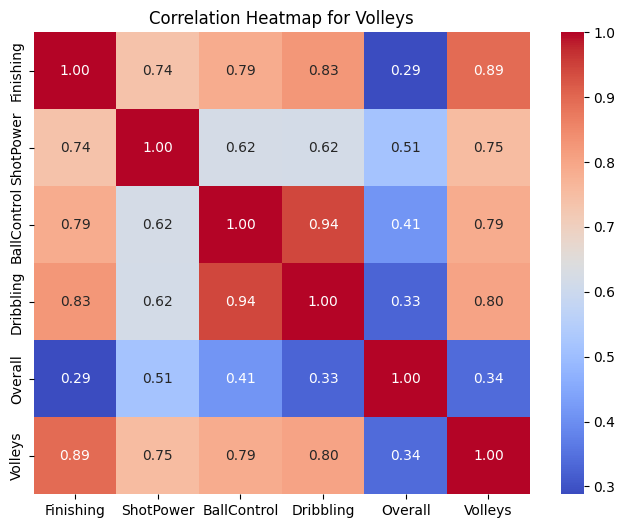

Step 9: Plotting actual vs predicted scatter plot...


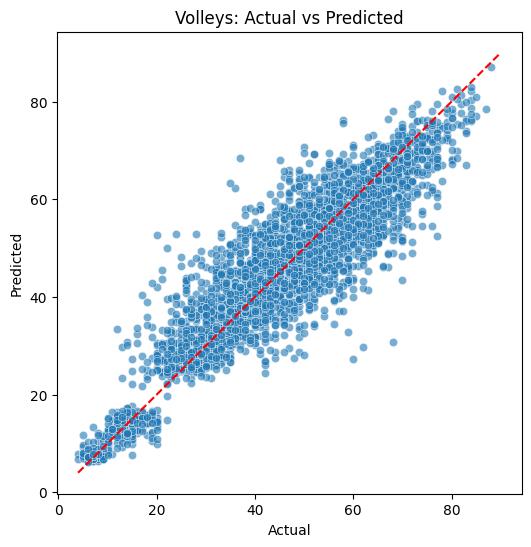


Step 10: Predicting missing values...
   → Found 37 missing 'Volleys' values. Predicting now...
Successfully filled 37 missing values for Volleys.

Finished processing attribute: Volleys


Starting prediction for attribute: Curve
Step 1: Ensuring position groups are defined...
Step 2: Selected input features: ['FKAccuracy', 'Crossing', 'BallControl', 'LongShots', 'Overall']
Step 3: Cleaning data and removing rows with missing predictor values...
Found 16673 valid samples with known 'Curve' values.
Step 4: Preparing model input data...
Step 5: Building preprocessing and model pipeline...
Step 6: Splitting data and training model...
Model training complete!
Step 7: Evaluating model performance...

Model Performance for Curve
   -> R² Score: 0.843
   -> Mean Absolute Error: 5.441

Step 8: Plotting correlation heatmap...


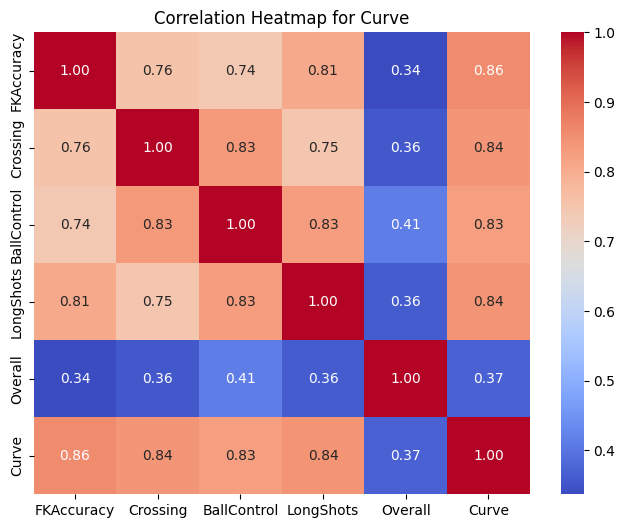

Step 9: Plotting actual vs predicted scatter plot...


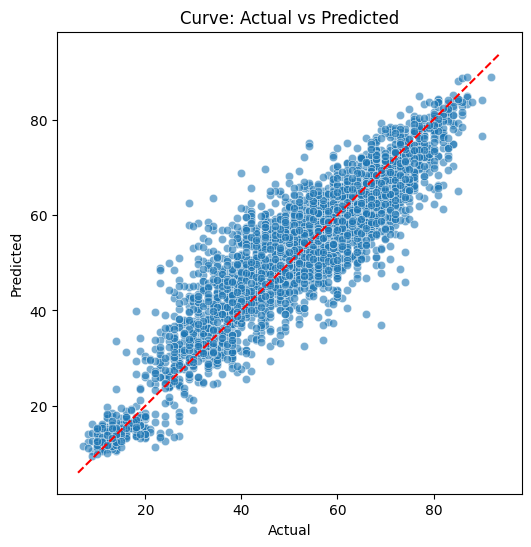


Step 10: Predicting missing values...
   → Found 37 missing 'Curve' values. Predicting now...
Successfully filled 37 missing values for Curve.

Finished processing attribute: Curve


Starting prediction for attribute: Agility
Step 1: Ensuring position groups are defined...
Step 2: Selected input features: ['Balance', 'Acceleration', 'Dribbling', 'Reactions', 'Overall']
Step 3: Cleaning data and removing rows with missing predictor values...
Found 16673 valid samples with known 'Agility' values.
Step 4: Preparing model input data...
Step 5: Building preprocessing and model pipeline...
Step 6: Splitting data and training model...
Model training complete!
Step 7: Evaluating model performance...

Model Performance for Agility
   -> R² Score: 0.792
   -> Mean Absolute Error: 4.941

Step 8: Plotting correlation heatmap...


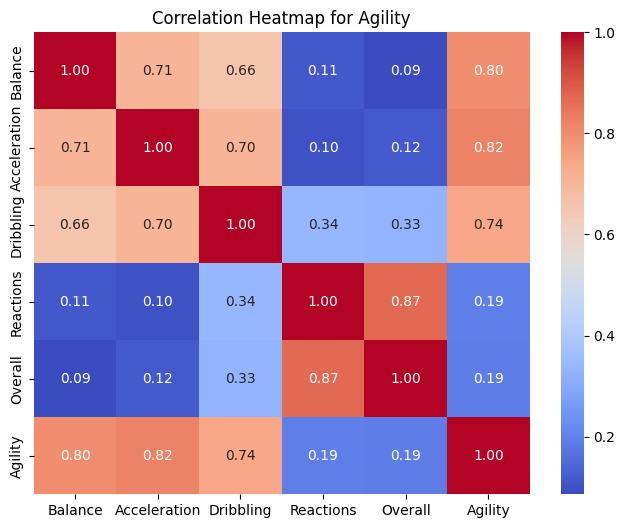

Step 9: Plotting actual vs predicted scatter plot...


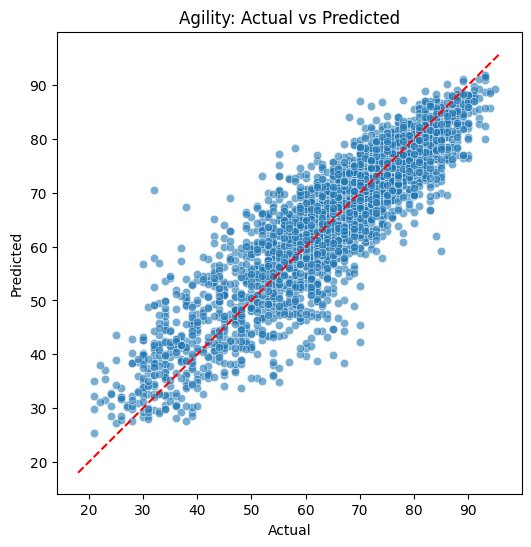


Step 10: Predicting missing values...
   → Found 37 missing 'Agility' values. Predicting now...
Successfully filled 37 missing values for Agility.

Finished processing attribute: Agility


Starting prediction for attribute: Balance
Step 1: Ensuring position groups are defined...
Step 2: Selected input features: ['Agility', 'Dribbling', 'Acceleration', 'Overall']
Step 3: Cleaning data and removing rows with missing predictor values...
Found 16673 valid samples with known 'Balance' values.
Step 4: Preparing model input data...
Step 5: Building preprocessing and model pipeline...
Step 6: Splitting data and training model...
Model training complete!
Step 7: Evaluating model performance...

Model Performance for Balance
   -> R² Score: 0.654
   -> Mean Absolute Error: 6.405

Step 8: Plotting correlation heatmap...


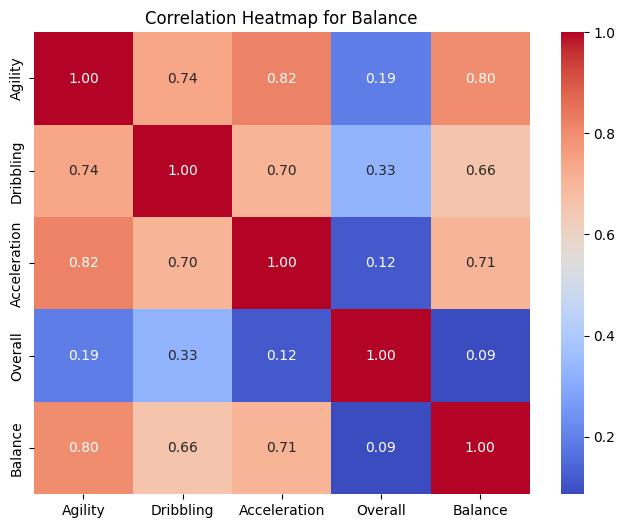

Step 9: Plotting actual vs predicted scatter plot...


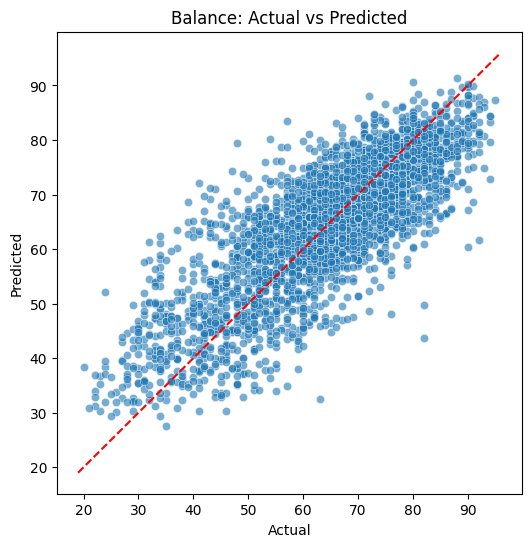


Step 10: Predicting missing values...
   → Found 37 missing 'Balance' values. Predicting now...
Successfully filled 37 missing values for Balance.

Finished processing attribute: Balance


Starting prediction for attribute: Jumping
Step 1: Ensuring position groups are defined...
Step 2: Selected input features: ['Strength', 'HeadingAccuracy', 'Aggression', 'Overall']
Step 3: Cleaning data and removing rows with missing predictor values...
Found 16673 valid samples with known 'Jumping' values.
Step 4: Preparing model input data...
Step 5: Building preprocessing and model pipeline...
Step 6: Splitting data and training model...
Model training complete!
Step 7: Evaluating model performance...

Model Performance for Jumping
   -> R² Score: 0.247
   -> Mean Absolute Error: 8.131

Step 8: Plotting correlation heatmap...


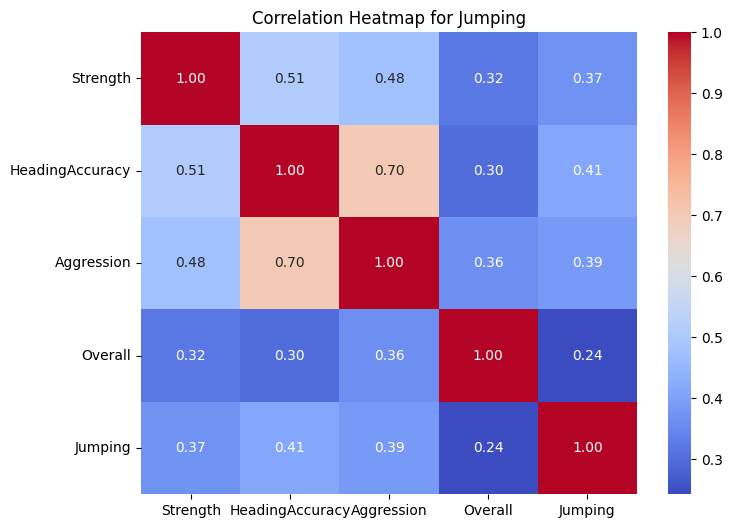

Step 9: Plotting actual vs predicted scatter plot...


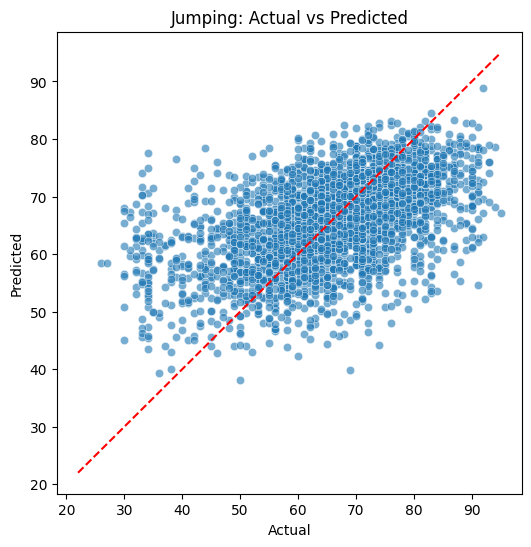


Step 10: Predicting missing values...
   → Found 37 missing 'Jumping' values. Predicting now...
Successfully filled 37 missing values for Jumping.

Finished processing attribute: Jumping


Starting prediction for attribute: Interceptions
Step 1: Ensuring position groups are defined...
Step 2: Selected input features: ['StandingTackle', 'DefensiveAwareness', 'Aggression', 'Overall']
Step 3: Cleaning data and removing rows with missing predictor values...
Found 15818 valid samples with known 'Interceptions' values.
Step 4: Preparing model input data...
Step 5: Building preprocessing and model pipeline...
Step 6: Splitting data and training model...


In [ ]:
missing_attributes = ['Volleys', 'Curve', 'Agility', 'Balance', 'Jumping',
                      'Interceptions', 'Positioning', 'Vision',
                      'Composure', 'Marking', 'SlidingTackle', 'DefensiveAwareness']

for attr in missing_attributes:
    df = predict_missing_attribute(df, attr)

In [ ]:
print(df.info())

## Now we have build the dataset, large enough to predict Marking

In [ ]:
df = predict_missing_attribute(df, 'Marking')

## Remove the intemediary column created and save the data set, will be used in EDA

In [ ]:
df = df.drop(columns=['PosGroup'])
df.head()

In [ ]:
print(df.info())

In [ ]:
df.to_csv("fifa22_null_removed.csv", index=False)

### Some features are predicted with good accuracy while others not, the accuracy can be improved much more; if we can give more time to correlation anaylsis and increase the feature vector size